In [15]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
def tokenize(text):
    punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
    text = text.lower()
    text = re.sub('#(\S+)', r'HASHTAG_\1', text)
    text = re.sub('@\S+', 'MENTION', text)
    text = re.sub('http\S+', 'THIS_IS_A_URL', text)
    text = re.sub(r'(.)\1\1\1+', r'\1', text)
    text = re.sub(r'[0-9]', '9', text)
    toks = []
    for tok in text.split():
        tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
        tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
        for subtok in tok.split():
            if re.search('\w', subtok):
                toks.append(subtok)
    return toks

In [65]:
vectorizer = TfidfVectorizer(decode_error='ignore',ngram_range=(1, 2), max_df=1., min_df=2,use_idf=True, tokenizer=tokenize)

In [66]:
DIR = '/data/2/protest'

In [67]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [68]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def iterate_instances(path, keywords, negative_window):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for fname in glob.glob(path + '/*.txt'):
        user = filename2user(fname)
        lines = []
        for i, line in enumerate(open(fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                yield (' '.join(lines), 1, user)
                yield (' '.join(lines[:-negative_window]), 0, user)
                break
            lines.append(js['text'])
            
y = []
users = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users), str(X.shape)))
print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
print(type(y))
#iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
#i=list(iterator)


read 570 instances into X matrix with shape (570, 1289249)
label distribution= Counter({0: 285, 1: 285})
<class 'list'>


In [69]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
y = np.array(y)
model_mod = LogisticRegression(penalty='l2', C=2.6)
model_mod.fit(X, y)


# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

# 10 Cross-validation accuracy
cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind],y[train_ind])   
    accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    
print('Average 10-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies)))

predicted = model_mod.predict(X)
print('accuracy on training data=%.4f' % accuracy(y, predicted))

Average 10-fold cross validation accuracy=0.5070 (std=0.01)
accuracy on training data=0.5912


In [70]:
from pprint import pprint 
coefs = sorted(zip(vectorizer.get_feature_names(), model_mod.coef_[0]),key=lambda x:x[1])
pprint(coefs[:30])
pprint(coefs[-30:])

[('MENTION acredito', -0.57389167443187339),
 ('acredito', -0.30455655876144622),
 ('ninguem gosta', -0.22858022845284878),
 ('um comunista', -0.21080474216813011),
 ('gosta mais', -0.18869955547649608),
 ('MENTION ninguem', -0.15390131056937204),
 ('vica', -0.14499037067039525),
 ('comunista', -0.1428552875564871),
 ('dinheiro do', -0.12880089602143444),
 ('no', -0.11013305513735402),
 ('da', -0.10454260385136857),
 ('q', -0.099142601741870506),
 ('via', -0.097257682262687981),
 ('ninguem', -0.092612175467488275),
 ('mais de', -0.091573668831712488),
 ('via MENTION', -0.086946883741631523),
 ('do que', -0.086381956522772377),
 ('oi larissa', -0.084431915986719633),
 ('THIS_IS_A_URL via', -0.083790964693914699),
 ('de dinheiro', -0.083396865045283722),
 ('que um', -0.077659776128477132),
 ('minha', -0.07427317332657829),
 ('pra', -0.072343193002620876),
 ('sua', -0.071354926485293138),
 ('gosta', -0.071225324510301863),
 ('mais', -0.07001123363890871),
 ('MENTION boa', -0.0655768571488

Results:

| negative_window      |   train acc  | test acc | n users |
| -------------------- | ------------ | -------- | ------- |
| 10                   | .591         | .507     | 285     |
| 20                   | .610         | .509     | 274     |
| 30                   | .614         | .515     | 264     |

In [11]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv(X, y, nfolds=10):
    y = np.array(y)
    cv = KFold(len(y), nfolds, shuffle=False)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))
  
#print(do_cv(X, y))

In [12]:
def create_feature_vector(iterator, vectorizer_):
    y=[]
    X = vectorizer_.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
    print('X dimensions=', X.shape)
    return X,y

Populating the interactive namespace from numpy and matplotlib
(1, 1)
X dimensions= (570, 36214)
(1, 2)
X dimensions= (570, 152438)
(2, 2)
X dimensions= (570, 116224)
(1, 3)
X dimensions= (570, 214327)
(2, 3)
X dimensions= (570, 178113)
(3, 3)
X dimensions= (570, 61889)


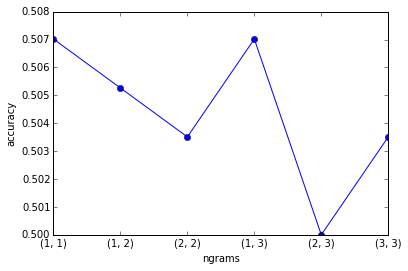

In [16]:
# How does using ngrams help?
def compare_ngrams(y):
    accuracies = []
    ngrams = [(1,1), (1,2), (2,2), (1,3), (2, 3), (3,3)]
    for ngram in ngrams:
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        print(ngram)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=True, tokenizer=tokenize, ngram_range=ngram, min_df=5))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(len(ngrams)), ngrams)
    plt.xlabel('ngrams')
    plt.ylabel('accuracy')
    plt.show()

#iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
compare_ngrams(y)

X dimensions= (518, 179177)
0.540648567119
X dimensions= (518, 179177)
0.540648567119
X dimensions= (518, 173511)
0.536802413273
X dimensions= (518, 48769)
0.529034690799
X dimensions= (518, 47240)
0.534803921569
X dimensions= (518, 30837)
0.536764705882
X dimensions= (518, 29878)
0.536689291101
X dimensions= (518, 22731)
0.530957767722
X dimensions= (518, 22025)
0.532918552036
X dimensions= (518, 17825)
0.527073906486
X dimensions= (518, 17230)
0.530957767722
X dimensions= (518, 14536)
0.534841628959
X dimensions= (518, 14063)
0.540648567119
X dimensions= (518, 12149)
0.534917043741
X dimensions= (518, 11739)
0.538687782805
X dimensions= (518, 10290)
0.534841628959
X dimensions= (518, 9927)
0.534841628959
X dimensions= (518, 8749)
0.540648567119
X dimensions= (518, 8424)
0.540610859729
X dimensions= (518, 7479)
0.536764705882


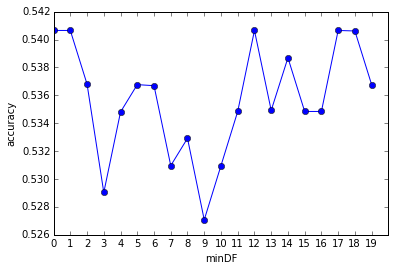

In [23]:
def compare_mindDF(y):
    a=None
    accuracies = []
    for freq in range(20):
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore', min_df=freq, ngram_range=(1,1),
                                                          max_df= 0.1, use_idf=True, tokenizer=tokenize))
        acc=do_cv(a[0],a[1])
        print(acc)
        accuracies.append(acc)
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(20))
    plt.xlabel('minDF')
    plt.ylabel('accuracy')
    plt.show()
compare_mindDF(y)

1.0
X dimensions= (570, 36214)
0.1
X dimensions= (570, 31440)
0.05
X dimensions= (570, 27253)
0.04
X dimensions= (570, 25319)
0.03
X dimensions= (570, 22286)
0.02
X dimensions= (570, 16507)
0.01
X dimensions= (570, 313)


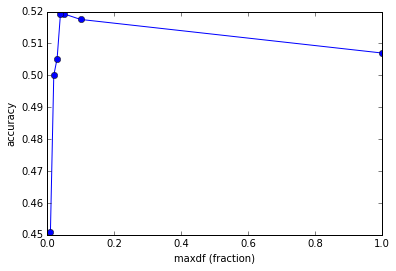

In [26]:
# How does filtering common words affect accuracy?
import matplotlib.pyplot as plt

def compare_maxdf(y):
    accuracies = []
    maxdfs = [1., .1, .05, .04, .03, .02, .01]
    for freq in maxdfs:
        print(freq)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore', max_df=freq, min_df=5, ngram_range=(1,1),
                             use_idf=True, tokenizer=tokenize))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(maxdfs, accuracies, 'bo-')
    plt.xlabel('maxdf (fraction)')
    plt.ylabel('accuracy')
    plt.show()
        
compare_maxdf(y)

True
X dimensions= (570, 184830)
False
X dimensions= (570, 184830)


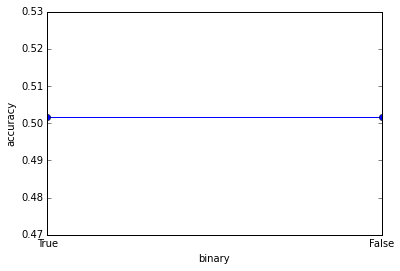

In [134]:
# Does binary/freq help?
def compare_binary(y):
    accuracies = []
    choices = [True, False]
    for choice in choices:
        print(choice)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=True, tokenizer=tokenize, binary=choice, norm='l2'))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks([0,1], [str(c) for c in choices])
    plt.xlabel('binary')
    plt.ylabel('accuracy')
    plt.show()
        
compare_binary(y)

True
X dimensions= (570, 184830)
False
X dimensions= (570, 184830)


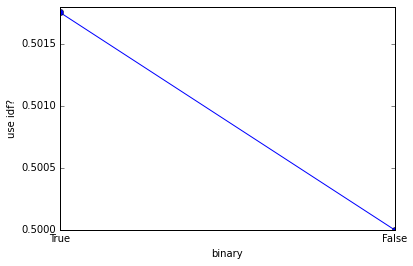

In [136]:
# Does idf help?
def compare_idf(y):
    accuracies = []
    choices = [True, False]
    for choice in choices:
        print(choice)
        iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
        a=create_feature_vector(iterator, TfidfVectorizer(decode_error='ignore',
                             use_idf=choice, tokenizer=tokenize, norm='l2'))
        accuracies.append(do_cv(a[0],a[1]))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks([0,1], [str(c) for c in choices])
    plt.xlabel('binary')
    plt.ylabel('use idf?')
    plt.show()
        
compare_idf(y)

In [7]:
# Do GridSearch on all parameters.
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint

#yy=np.array(y)
pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore')),
    ('clf', LogisticRegression()),
])

parameters = {
    #'vect__min_df': (1, 2, 3, 4, 5,6,7,8),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3),(2,2),(2,3)),  # unigrams or bigrams or trigrams
    #'vect__use_idf': (True, False),
    'vect__max_df':(1., .1, .05, .04, .03, .02),
    #'vect__tokenizer':(None, tokenize)
}

iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
data = [item[0] for item in i]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10,shuffle=False))

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
grid_search.fit(data, y)
print("done.")

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed: 28.0min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed: 109.1min
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 161.5min finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (1.0, 0.1, 0.05, 0.04, 0.03, 0.02),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3))}
Fitting 10 folds for each of 30 candidates, totalling 300 fits
done.
Best score: 0.546
Best parameters set:
	vect__max_df: 0.1
	vect__ngram_range: (1, 1)


In [ ]:
len(i)